In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ujipenchars2
from drawing import Drawing
from preprocessing import DrawingToBoxScaler, DrawingResampler
from dtw import dtw_distance_matrix
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump
from platform import python_version
import string

print(python_version())

3.9.1


In [2]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)
data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([drawing.label for drawing in data])

drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
data = drawing_scaler.transform(data)

drawing_resampler = DrawingResampler(50)
data = drawing_resampler.transform(data)

stacked_data = np.stack([np.vstack(drawing.strokes) for drawing in data])

D = dtw_distance_matrix(stacked_data, stacked_data[train_idx])

In [3]:
def plot_drawings(drawings: list[Drawing], ncols=2,):
    n = len(drawings)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, sharex=True)
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            drawing = drawings[k]
            plt.title(drawing.label)
            for stroke in drawing.strokes:
                axes[i, j].plot(stroke[:,0], stroke[:,1], color='black', linewidth=1, solid_capstyle='round')
            plt.axis('scaled')
            k += 1

In [4]:
np.fill_diagonal(D, 2*np.max(D))
def findK(D, train, labels):
    n = len(train)
    maxScore = 0
    bestK = 0
    for k in range(1, 20):
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute', metric='precomputed')
        knn.fit(D[:n, :n], labels[:n]) #train data, train data
        score = knn.score(D[:n, :n], labels[:n])*100 #test data, train data
        print(k, score)
        if score > maxScore:
            maxScore = score
            bestK = k
    return bestK

bestK = findK(D, train, labels)
print('Best: k =', bestK)

1 99.625
2 99.625
3 99.25
4 99.125
5 98.625
6 98.875
7 98.75
8 98.75
9 98.75
10 98.75
11 98.375
12 98.375
13 98.25
14 98.25
15 98.125
16 98.0
17 97.875
18 97.625
19 97.625
Best: k = 1


In [5]:
def knn(D, train, test, labels, k=bestK):
    n = len(train)
    m = len(test)
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute', metric='precomputed')
    knn.fit(D[:n, :n], labels[:n]) #train data, train data
    predict = knn.predict(D[n:, :n]) #test data, train data
    wrong_indices = []
    for i in range(m):
        if predict[i] != labels[i]:
            wrong_indices.append(i)
    score = knn.score(D[n:, :n], labels[n:])*100 #test data, train data
    return wrong_indices, score

k =  1 , score =  98.0
[20, 21, 36, 37, 239, 273, 318, 348]


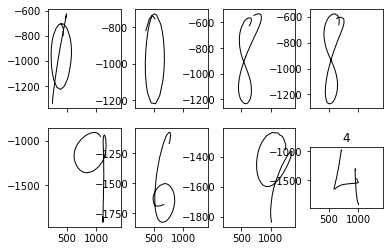

In [6]:
k = bestK
wrong_indices, score = knn(D, train, test, labels, k)
print("k = ", k, ", score = ", score)
print(wrong_indices)
wrong_drawings = [train[i] for i in wrong_indices]
plot_drawings(wrong_drawings, ncols=4)